# Driver of Dynamic Mode Neural Network (DMNet)

The architecture of DMNet is similar to ResDMD as a neural network extension of linear inverse model (LIM) or Dynamic Mode Decomposition (DMD)

The model integration uses `odeint` from `torchdiffeq`, which is a general-purpose PyTorch algorithm for solving initial value problems. The algorithm solves an initial value problem for an ODE from $t=t_0$ to $t=t_0+\tau$.
$$
\frac{dy}{dt} = f(t, y)
$$
with an initial value,
$$
y(t_0) = y_0.
$$
See the github repo: https://github.com/rtqichen/torchdiffeq

## Import Modules

In [7]:
# import modules
import math
import numpy as np
import os

import matplotlib as mpl
mpl.rc('image', cmap='jet')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# %matplotlib inline

# from dmnet_mod import LIM

import torch
gpu = 0
device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')

from ode_mod import NeuralODE, OdeDataset, OdeModel, OdeTrainer

## Data

In [8]:
# # data
# # test of dataloader
# y = np.linspace(0,9,10).astype('float32')
# t = np.linspace(0,9,10).astype('float32')

if False:
    # red noise
    from ode_AM_index_config import get_red_noise as get_data
    gamma = [0.06]
    true_t, true_y = get_data(gamma=gamma, data_size=10000)
else:
    # annular mode
    from read_AM_index_mod import get_AM_index as get_data
    t, y, p = get_data()

t_T = torch.from_numpy(t)
if y.ndim == 1:
    y_T = torch.from_numpy(y)[:,None]
else:
    y_T = torch.from_numpy(y)

print(f't.shape = {t_T.shape}, y.shape = {y_T.shape}')
# plot(true_y)


Reading from saved data ......
Use pressure levels = [   1.    2.    3.    5.    7.   10.   20.   30.   50.   70.  100.  125.
  150.  175.  200.  225.  250.  300.  350.  400.  450.  500.  550.  600.
  650.  700.  750.  775.  800.  825.  850.  875.  900.  925.  950.  975.
 1000.]

t.shape = torch.Size([21535]), y.shape = torch.Size([21535, 37])


diagonal(vrH_vr)=
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])
norm(vlH - vlH @ vr @vlH) = 71.40375518798828
norm(vr - vr @ vlH @vr) = 0.10847669839859009
norm(a - vr @ diag(w) @vlH) = 7.834300518035889
diagonal(vrH_vr)=
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])
norm(vlH - vlH @ vr @vlH) = 0.017221974208950996
norm(vr - vr @ vlH @vr) = 8.313406578963622e-05
norm(a - vr @ diag(w) @vlH) = 0.009917683899402618
te

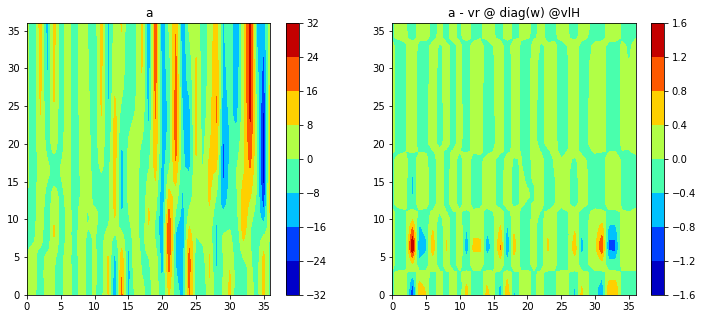

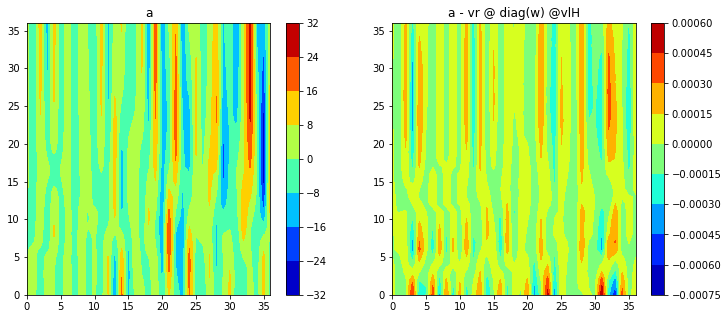

In [21]:
from torch import linalg as la

#=============================================================
# function eig_m()
# modified version of eigenvector decomposition: ``w, vl, vr = eig_m(a)``
#=============================================================
def eig_m(a, method='eig2', verbose=False):
    """
    modified version of eigenvector decomposition:
    ``w, vl, vr = eig_m(a)``

    Factorizes the square matrix `a` into the normalized eigenvector matrix ``vr``, its inverse ``vl.H``, and
    a 1-D array ``w`` of eigenvalues: \\
    ``a @ vr = vr @ np.diag(w)`` or ``a = vr @ np.diag(w) @ vl.H`` \\
    where ``vl`` and ``vr`` are biorthogonal bases, `vr @ vl.H = I`, and `vl.H @ vr = I`.

    method options:
    eig1: solve vl and vr simulateneously by calling `eig` in scipy
    eig2: solve vl and vr separately by calling `eig` twice
    pinv: solve vr by calling `eig`, and then solve vl by calling `pinv`
    """

    # function to sort eigenvectors v by the decending order of eigenvalues w, with the option to sort by w.congj()
    def eig_sort(w, v, sort_by_w=True):
        if sort_by_w:
            idx_np = w.numpy().argsort()[::-1]
            idx_w_sort = torch.from_numpy(idx_np.copy())
        else:
            idx_np = w.numpy().conj().argsort()[::-1]
            idx_w_sort = torch.from_numpy(idx_np.copy())    # sort by w.conj()

        w_sort = torch.zeros_like(w)
        v_sort = torch.zeros_like(v)
        for idx, idx_sort in enumerate(idx_w_sort):
            w_sort[idx] = w[idx_sort]
            v_sort[:, idx] = v[:, idx_sort]

        return w_sort, v_sort

    # perform eigendecomposition
    if method == 'eig1':
        w1, vl1, vr1 = la.eig(a, left=True)
        w, vr = eig_sort(w1, vr1)
        _, vl = eig_sort(w1, vl1)
    
    elif method == 'eig2':
        w1, vr1 = la.eig(a)
        w, vr = eig_sort(w1, vr1)

        w2, vl2 = la.eig(a.conj().T)
        _, vl = eig_sort(w2, vl2, sort_by_w=False)
    
    elif method == 'pinv':
        w1, vr1 = la.eig(a)
        w, vr = eig_sort(w1, vr1)

        vl = la.pinv(vr).conj().T
    
    else:
        raise Exception('The method for eigenvector decomposition is not specified!')

    # form a biorthogonal system
    # note the transpose operator (.T) in python differs from the operator (') in matlab for a complex
    vlH_vr = vl.conj().T @ vr
    for idx in range(len(w)):
        vl[:, idx] = vl[:, idx]/(vlH_vr[idx, idx].conj())

    if verbose:
        # To ensure the biorthogonality, vr is normalized, but vl is not normalized in the modified version 
        vrH_vr = vr.conj().T @ vr
        print(f"diagonal(vrH_vr)=\n{torch.diagonal(vrH_vr).real}")

        vlH_c = vl.conj().T @ vr @ vl.conj().T
        print(f"norm(vlH - vlH @ vr @vlH) = {la.norm(vl.conj().T-vlH_c)}")

        vr_c = vr @ vl.conj().T @ vr
        print(f"norm(vr - vr @ vlH @vr) = {la.norm(vr-vr_c)}")

        a_c = vr @ torch.diag(w) @ vl.conj().T
        print(f"norm(a - vr @ diag(w) @vlH) = {la.norm(a-a_c)}")

        fig = plt.figure(figsize=(12,5))
        ax = fig.add_subplot(1, 2, 1)
        plt.contourf(a.numpy(), cmap='jet')
        plt.title('a')
        plt.colorbar()

        ax = fig.add_subplot(1, 2, 2)
        plt.contourf((a-a_c).numpy().real, cmap='jet')
        plt.title('a - vr @ diag(w) @vlH')
        plt.colorbar()
        
    return w, vl, vr

def cal_Gt(X, lag):
        data_size = len(X)
        C0 = X.T @ X / data_size
        Ct = X[lag:].T @ X[0:data_size-lag] / (data_size-lag)

        C0_inv = la.pinv(C0)    # pseudo-inverse for a singular matrix
        Gt = Ct @ C0_inv
        return Gt

def test_eig_m(X, lag):
        Gt = cal_Gt(X, lag) 
        # w1, vl1, vr1 = eig_m(Gt, method='eig1', verbose=True)
        w2, vl2, vr2 = eig_m(Gt, method='eig2', verbose=True)
        w3, vl3, vr3 = eig_m(Gt, method='pinv', verbose=True)
        b = torch.log(w2)/lag
        print(b)

test_eig_m(y_T, 5)

In [14]:

#=============================================================
# class LIM()
# Linear Inverse Model
#=============================================================
class LIM():
    def __init__(self, X, lag, method='eig2', verbose=False):
        """
        POP analysis described in Penland (1989) 
        X(t, x): input data, where t is time, and x is space
        lag: lag time used to compute Ct

        The propagation matrix is calculated as
        `Gt = Ct @ C0_inv`.

        The eigenvector decomposition of the propagation matrix (using the function `eig_m`) is 
        `Gt @ vr = vr @ np.diag(w)` or `Gt = vr @ np.diag(w) @ vl.H`, \\
        where vl and vr are biorthogonal bases, `vr @ vl.H = I`, and `vl.H @ vr = I`.

        The projection of `x` in the eigenvector space is
        `pc(t, eig) = (vl.H @ X.H).H = X @ vl`, \\
        and the reconstruction in the physical space is
        `X(t, x) = (vr @ pc.H).H = pc @ vr.H`.

        method options:
        eig1: solve vl and vr simulateneously by calling `eig` in scipy
        eig2: solve vl and vr separately by calling `eig` twice
        pinv: solve vr by calling `eig`, and then solve vl by calling `pinv`
        """

        self.w, self.vl, self.vr, self.b, self.B = self.pop(X, lag, method=method, verbose=verbose)

    def pop(self, X, lag, method='eig2', verbose=False):
        data_size = len(X)
        C0 = X.T @ X / data_size
        Ct = X[lag:].T @ X[0:data_size-lag] / (data_size-lag)

        C0_inv = la.pinv(C0)    # pseudo-inverse for a singular matrix
        Gt = Ct @ C0_inv

        w, vl, vr = eig_m(Gt, method=method, verbose=verbose)
        b = torch.log(w)/lag
        B = vr @ torch.diag(b) @ vl.conj().T
        if verbose:
            print(f"POP e-folding timescales =\n {-1/b.real}")

        return w, vl, vr, b, B

    def forecast(self, X, lag):
        """
        X(batch, x): batch of initial conditions
        lag: time lags to be forecasted
        return y(lag, batch, x): batch forecasts at time lag starting from X
        """
        
        y = torch.zeros((0, *X.shape))
        for idx in range(len(lag)):
            Gt = self.vr @ torch.diag(torch.exp(self.b * lag[idx])) @ self.vl.conj().T
            Xt = (Gt.real @ X.T).T
            y = torch.vstack((y, Xt[None, :]))
        
        return y


diagonal(vrH_vr)=
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])
norm(vlH - vlH @ vr @vlH) = 71.40375518798828
norm(vr - vr @ vlH @vr) = 0.10847669839859009
norm(a - vr @ diag(w) @vlH) = 7.834300518035889
POP e-folding timescales =
 tensor([ -5.2087, -52.2738, -52.2738,  23.6905,  17.7248,  16.7176,  16.7176,
         38.3850,  38.3850,   9.3693,   9.3693,   7.8250,   6.6373,   6.6373,
          5.8306,   9.9117,   9.9117,   4.6006,   4.7769,   4.7769,   3.8330,
          3.8330,   2.8113,   3.2683,   3.2683,   1.8898,   1.9165,   1.9165,
          1.4335,   1.4335,   1.5512,   3.0284,   3.0284,   8.2028,   8.2028,
          2.8536,  -7.1477])

y(t, x) = torch.Size([21535, 37])
yf(lag, batch, x) = tor

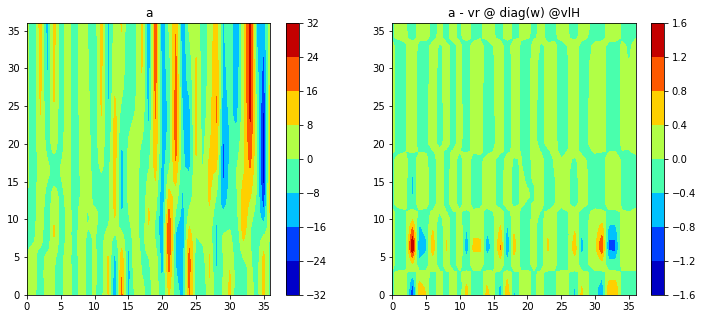

In [16]:
lag = 5
model = LIM(y_T, lag=lag, method='eig2', verbose=True)

lag_time = 90
yf_T = model.forecast(y_T[:-lag_time], t_T[:lag_time+1])
print(f"\ny(t, x) = {y_T.shape}")
print(f"yf(lag, batch, x) = {yf_T.shape}")

## Hyperparameters

In [ ]:
# hyperparameters
hyp_param = dict(ode = dict(adjoint = False, # False
                            method = 'midpoint',
                            options = dict(step_size=1.0),    # step_size for fixed grid ODE solver in unit of t
                           ),
                                       
                 data = dict(batch_size = 20,    # 20, 200, # size of mini-batch
                             batch_time = 10,    # 10,    # the length in 't' integrated by odeint (cf. lag in LIM)
                             test_frac = 0,     # 0.1,    # fraction of 'dataset' used for test data
                             First_batch_only = False, #False,    # overfit the first batch only for the purpose of debugging
                            ),
                
                train = dict(epochs = 10,   # 40, 20  # number of epochs
                             output_freq = 500,    # output per the number of batches for each epoch
                             lr_scheduler = dict(method = None,    # None, 'StepLR', ...
                                                 # if `method = StepLR`, 
                                                 # the learning rate decays by gamma every step_size epochs
                                                 StepLR = dict(step_size=5, gamma=0.5),
                                                ),
                             max_norm = None,    # maximum norm used to clip the norms of model parameters
                            ),     

                # L1 loss is more robust to outliers, but its derivatives are not continuous
                # L2 loss is sensitive to outliers, but gives a more stable and closed form solution
                loss_fn = dict(method = 'MSELoss', # 'MSELoss', 'L1Loss'
                              ),

                # https://ruder.io/optimizing-gradient-descent/
                # RMSprop is an adaptive learning rate algorithm
                # Adam adds bias-correction and momentum to RMSprop.
                optimizer = dict(method = 'RMSprop',     # 'RMSprop', 'Adam', 'SGD'
                                learning_rate = 1e-3,    # 1e-3,    # default LR
                                RMSprop = dict(),
                                Adam = dict(),
                                SGD = dict(momentum=0, weight_decay=0),
                                ),

                func = dict(method = 'Tanh',
                            size = [y_T.shape[1]]*3,
                           ),
                )
hyp_param['train']['First_batch_only'] = hyp_param['data']['First_batch_only']

print(f'hyperpamameters:\n{hyp_param}')

## Model

In [ ]:
nn = NeuralODE(y_T, t_T, hyp_param, verbose=False)

## Analysis

In [ ]:
## plot(t, true_y, lag_time=50, model=model)
# for name, param in nn.model.named_parameters():
#     print(f'params: {name}, {param}')

In [ ]:
print(nn.trainer.save.keys())
print(len(nn.trainer.save["train_loss"]))
nn.trainer.plot_loss(log_scale=True)

In [ ]:
lag_time = 90
with torch.no_grad():
    yf= np.squeeze(nn.model(y_T[:-lag_time], t_T[:lag_time+1]).detach().numpy())


In [ ]:
from AM_plot_mod import plot_cov

k = np.isin(p, 10).nonzero()[0][0]
plot_cov(y, yf=yf, k=k, lag_time=lag_time, model_name='NN')


In [ ]:
from AM_plot_mod import plot_lag_reg

plot_lag_reg(y, p, yf, model_name='NN')

In [ ]:
from AM_plot_mod import plot_event

plot_event(y, p, yf=yf, lag_time=lag_time, model_name='NN')
